Training of DnCNN for Denoising
===============================

This example demonstrates the training and application of the DnCNN model
from <cite data-cite="zhang-2017-dncnn"/> to denoise images that have been corrupted
plot.config_notebook_plotting()
with additive Gaussian noise.

In [1]:
import os
from time import time

import numpy as np

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_image_data

Prepare parallel processing. Set an arbitrary processor count (only
applies if GPU is not available).

In [2]:
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
platform = jax.lib.xla_bridge.get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [3]:
size = 40  # patch size
train_nimg = 400  # number of training images
test_nimg = 16  # number of testing images
nimg = train_nimg + test_nimg
gray = True  # use gray scale images
data_mode = "dn"  # Denoising problem
noise_level = 0.1  # Standard deviation of noise
noise_range = False  # Use fixed noise level
stride = 23  # Stride to sample multiple patches from each image


train_ds, test_ds = load_image_data(
    train_nimg,
    test_nimg,
    size,
    gray,
    data_mode,
    verbose=True,
    noise_level=noise_level,
    noise_range=noise_range,
    stride=stride,
)

Data read from path       :   ~/.cache/scico/examples/data
Set --training--          :   Size:   104000
Set --testing --          :   Size:   4160
Data range -- images --   :    Min:   0.00, Max: 1.00


Data range -- labels --   :    Min:   0.00, Max: 1.00
NOTE: If blur kernel or noise parameter are changed, the cache must be manually
      deleted to ensure that the training data is regenerated with the new
      parameters.


Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively
short training. The depth of the model has been reduced to 6, instead of
the 17 of the original model. The suggested settings can be found in the
original paper.

In [4]:
# model configuration
model_conf = {
    "depth": 6,
    "num_filters": 64,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 0,
    "opt_type": "ADAM",
    "batch_size": 128,
    "num_epochs": 50,
    "base_learning_rate": 1e-3,
    "warmup_epochs": 0,
    "log_every_steps": 5000,
    "log": True,
    "checkpointing": True,
}

Construct DnCNN model.

In [5]:
channels = train_ds["image"].shape[-1]
model = sflax.DnCNNNet(
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
)

Run training loop.

In [6]:
workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "dncnn_out")
train_conf["workdir"] = workdir
print(f"\nJAX local devices: {jax.local_devices()}\n")

trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)
modvar, stats_object = trainer.train()


JAX local devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3), cuda(id=4), cuda(id=5), cuda(id=6), cuda(id=7)]



channels: 1   training signals: 104000   testing signals: 4160   signal size: 40



Network Structure:
+---------------------------------+----------------+--------+-----------+--------+
| Name                            | Shape          | Size   | Mean      | Std    |
+---------------------------------+----------------+--------+-----------+--------+
| ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ConvBNBlock_0/Conv_0/kernel     | (3, 3, 64, 64) | 36,864 | -0.000522 | 0.0589 |
| ConvBNBlock_1/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ConvBNBlock_1/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ConvBNBlock_1/Conv_0/kernel     | (3, 3, 64, 64) | 36,864 | 0.000178  | 0.0589 |
| ConvBNBlock_2/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ConvBNBlock_2/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ConvBNBlock_2/Conv_0/kernel     | (3, 3, 64, 64) | 36,864 | 5.46e-

Initial compilation, which might take some time ...


Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    6  4.83e+01  0.001000    0.001956      13.20   0.001002     14.35


   12  9.19e+01  0.001000    0.000936      14.34   0.001037     14.20


   18  1.35e+02  0.001000    0.000873      14.64   0.001203     13.59


   24  1.77e+02  0.001000    0.000841      14.81   0.000846     15.11


   30  2.20e+02  0.001000    0.000819      14.92   0.001017     14.31


   36  2.63e+02  0.001000    0.000806      14.99   0.000848     15.09


   43  3.05e+02  0.001000    0.000799      15.03   0.000902     14.83


   49  3.48e+02  0.001000    0.000793      15.06   0.000875     14.95


Evaluate on testing data.

In [7]:
test_patches = 720
start_time = time()
fmap = sflax.FlaxMap(model, modvar)
output = fmap(test_ds["image"][:test_patches])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)

Evaluate trained model in terms of reconstruction time and data fidelity.

In [8]:
snr_eval = metric.snr(test_ds["label"][:test_patches], output)
psnr_eval = metric.psnr(test_ds["label"][:test_patches], output)
print(
    f"{'DnCNNNet training':18s}{'epochs:':2s}{train_conf['num_epochs']:>5d}"
    f"{'':21s}{'time[s]:':10s}{trainer.train_time:>7.2f}"
)
print(
    f"{'DnCNNNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}"
    f"{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

DnCNNNet training epochs:   50                     time[s]:   353.55
DnCNNNet testing  SNR: 15.18 dB   PSNR: 27.56 dB   time[s]:     3.38


Plot comparison. Note that plots may display unidentifiable image
fragments due to the small patch size.

/tmp/ipykernel_3075616/2481856888.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


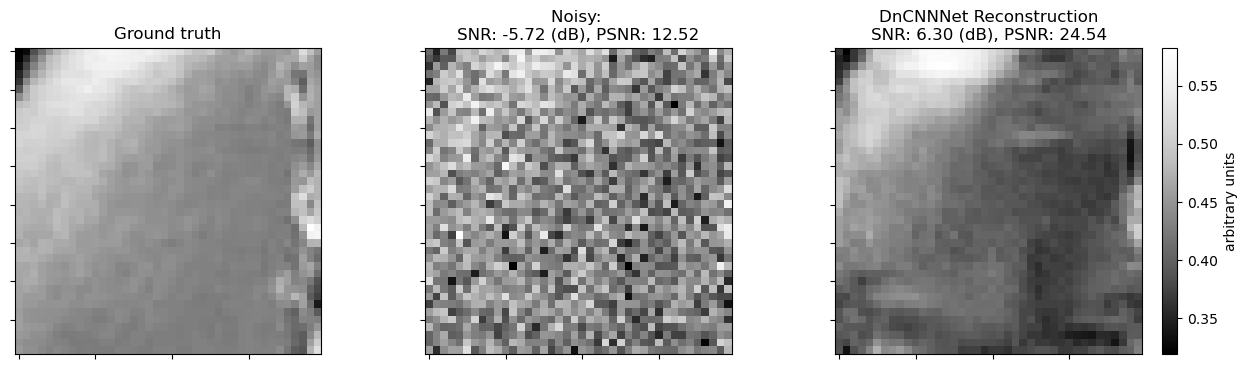

In [9]:
np.random.seed(123)
indx = np.random.randint(0, high=test_patches)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Noisy: \nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
    ),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="DnCNNNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

/tmp/ipykernel_3075616/3668777957.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


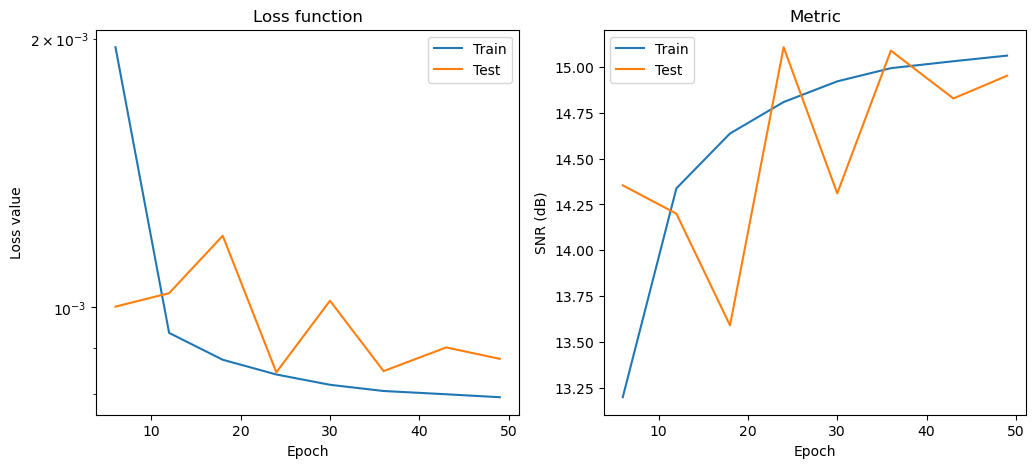

In [10]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()